# M5 Forecast: Poisson loss (top 10%)

This very simple script was lucky enough to get top 10% in private lb. 

I moved the time horizon of the previous version of this notebook by 28 days and removed all "magic" stuff. The winning solutions did clearly better in terms of performance, but simplicity is worth a lot when it comes to maintainance etc.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/kaggle/

/content/drive/MyDrive/Colab_Notebooks/kaggle


In [3]:
# # !pip install -r ./m5-forecasting/requirements.txt
# !pip install polars -q
# !git config --global user.email "yoggibear6@gmail.com"
# !git config --global user.name "yjtek"
# !git checkout -f main

In [4]:
# !git pull && git add . && git commit -m "push colab changes" && git push origin main

In [5]:
import pandas as pd
import polars as pl
import numpy as np
import os
import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split


In [25]:
pl.Config.set_tbl_rows(999)
pl.Config.set_tbl_cols(999)
pl.Config.set_tbl_width_chars(999)
pl.Config.set_fmt_str_lengths(999) 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

## Load data

In [7]:
# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/ 
# !chmod 600 ~/.kaggle/kaggle.json
# !bash ./m5-forecasting/getfiles.sh

In [8]:
path = "./m5-forecasting/data"
calendar = pl.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pl.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission_accuracy = pl.read_csv(os.path.join(path, "sample_submission_accuracy.csv"))
sales = pl.read_csv(os.path.join(path, "sales_train_evaluation.csv"))

## Prepare Calendar

In [10]:
def prep_calendar(df):
    featnames = ["event_name_1", "event_name_2"]
    ord_enc = OrdinalEncoder()
    featvals = ord_enc.fit_transform(calendar.select(featnames).to_numpy()) + 1

    df2 = (
        df
        .drop("date", "weekday", "event_type_1", "event_type_2")
        .with_columns(
            pl.col('d').str.replace('d_', '').cast(pl.Int64).alias('d')
        )
        .pipe(
            lambda df: (
                df.with_columns([
                    pl.Series(name=f'{featname}', values=featval) for featname, featval in zip(featnames, featvals.T)
                ])
            )
        )
        # .pipe(
        #     lambda df: (
        #         df.select(
        #             [pl.col(int8col).cast(pl.Int8).alias(int8col) for int8col in 
        #              ["wday", "month",  "snap_CA", "snap_TX", "snap_WI"] + featnames] +
        #              [pl.col(int16col).cast(pl.Int16).alias(int16col) for int16col in
        #               ['wm_yr_wk', 'year', 'd']]
        #         )
        #     )
        # )
        .select('wm_yr_wk', 'wday', 'month', 'year', 'd', 'event_name_1', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI')
    )

    return df2

calendar_final = prep_calendar(calendar)
calendar_final.head()

wm_yr_wk,wday,month,year,d,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI
i64,i64,i64,i64,i64,f64,f64,i64,i64,i64
11101,1,1,2011,1,31.0,5.0,0,0,0
11101,2,1,2011,2,31.0,5.0,0,0,0
11101,3,1,2011,3,31.0,5.0,0,0,0
11101,4,2,2011,4,31.0,5.0,1,1,0
11101,5,2,2011,5,31.0,5.0,1,0,1


In [9]:
selling_prices.head() #.dtypes #.with_columns(pl.col('item_id').cast(pl.))

store_id,item_id,wm_yr_wk,sell_price
str,str,i64,f64
"""CA_1""","""HOBBIES_1_001""",11325,9.58
"""CA_1""","""HOBBIES_1_001""",11326,9.58
"""CA_1""","""HOBBIES_1_001""",11327,8.26
"""CA_1""","""HOBBIES_1_001""",11328,8.26
"""CA_1""","""HOBBIES_1_001""",11329,8.26


## Helper functions

We need the following functions.

In [49]:
LAGS = [7, 28]
WINDOWS = [7, 28]
FIRST_EVAL_DAY = 1942 # first to predict
LENGTH_EVAL_WINDOW = 28
DROP_FIRST_N_DAYS = 1600

def make_demand_features(df: pl.DataFrame):
    """ Derive features from sales data and remove rows with missing values """
    df2 = (
        df
        .with_columns(pl.col('demand').shift(1).over('id').cast(pl.Float32).alias(f'demand_lag1'))        
        .with_columns(*[
            pl.col('demand_lag1').shift(lag).over('id').cast(pl.Float32).alias(f'lag_t{lag}')
            for lag in LAGS
        ])
        .with_columns(*[
            pl.col(f'lag_t{lag}').rolling_mean(window_size=window).over('id').cast(pl.Float32).alias(f'rolling_mean_lag{lag}_window{window}')
            for lag in LAGS
            for window in WINDOWS
        ])
        .filter(pl.col(f'rolling_mean_lag{max(LAGS)}_window{max(WINDOWS)}').is_not_null())
    )
    return df2

def drop_data_beyond_xdays(df: pl.DataFrame, x: int):
    df2 = (
        df
        .drop([f'd_{col+1}' for col in range(x)])
    )
    return df2

def clean_id_string(df:pl.DataFrame):
    df2 = (
        df
        .with_columns(pl.col('id').str.replace('_evaluation', ''))
    )
    return df2

def add_evaluation_days(df: pl.DataFrame, first_eval_day: int, length_eval_window: int):
    df2 = (
        df
        .select(*['*'] + [pl.lit(None).alias(f'd_{first_eval_day + x}') for x in range(length_eval_window)])
    )
    return df2

def pivot_wide_to_long(df: pl.DataFrame):
    df2 = (
        df
        .melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], variable_name='d', value_name='demand')
        .with_columns(pl.col('d').str.replace('d_', '').cast(pl.Int64), pl.col('demand').cast(pl.Float32))
    )
    return df2

def add_ordinal_encoding(df: pl.DataFrame, cols: list[str]) -> pl.DataFrame:
    # for col in cols:
    ord_enc = OrdinalEncoder()
    rawvals = df.select(cols).to_numpy()
    featvals = ord_enc.fit_transform(rawvals).T
    df2 = df.with_columns(*[pl.Series(name=col, values=val) for col, val in zip(cols, featvals)])
    return df2

def split_train_valid_test(df: pl.DataFrame, first_eval_day: int, lags: list[int], windows: list[int]):
    test = (
        df.filter(pl.col('d') >= first_eval_day - max(lags) - max(windows) - 28)
    )
    trainval = (
        df.filter(pl.col('d') < first_eval_day)
    )

    xfeats = [x for x in trainval.columns if x not in ['id', 'd', 'demand']]

    xtrain, xval, ytrain, yval = train_test_split(trainval.drop(['id', 'd', 'demand']).to_pandas(), trainval['demand'].to_numpy(), test_size=0.3, random_state=123)
    train = lgb.Dataset(xtrain, label = ytrain)
    valid = lgb.Dataset(xval, label = yval)
    return train, valid, test, xfeats

def prep_data(df, first_eval_day: int, length_eval_window: int, drop_days: int, lags: list[int], windows: list[int]):
    """ Prepare model data sets """
    df = (
        sales
        .pipe(lambda df: drop_data_beyond_xdays(df, drop_days))
        .pipe(lambda df: clean_id_string(df))
        .pipe(lambda df: add_evaluation_days(df, first_eval_day=first_eval_day, length_eval_window=length_eval_window))
        .pipe(lambda df: pivot_wide_to_long(df))
        .pipe(lambda df: make_demand_features(df))
        
        .join(calendar_final, how='left', on='d')
        .join(selling_prices, how='left', on=["store_id", "item_id", "wm_yr_wk"])
        .drop('wm_yr_wk')

        .pipe(lambda df: add_ordinal_encoding(df, ["dept_id", "item_id", "store_id", "state_id", "cat_id"]))
    )

    train, valid, test, xfeats = split_train_valid_test(df, first_eval_day=first_eval_day, lags=lags, windows=windows)
    return train, valid, test, xfeats

In [29]:
train, valid, test, xfeats = prep_data(sales, first_eval_day=FIRST_EVAL_DAY, length_eval_window=LENGTH_EVAL_WINDOW, drop_days=DROP_FIRST_N_DAYS, lags=LAGS, windows=WINDOWS)

In [37]:
# import gc
# gc.collect()

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 6082755, number of used features: 21
[LightGBM] [Info] Start training from score 0.274002
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's rmse: 3.41103


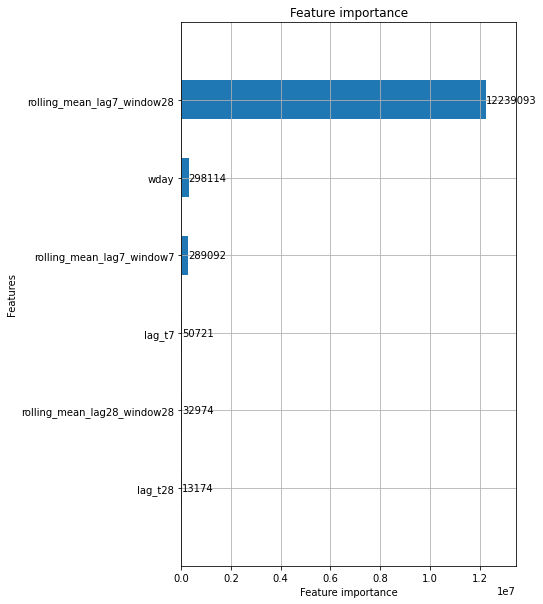

In [33]:
def fit_model(train: lgb.Dataset, valid: lgb.Dataset):
    """ Fit LightGBM model """
     
    params = {
        'metric': 'rmse',
        'objective': 'poisson',
        'seed': 200,
        'force_row_wise' : True,
        'learning_rate' : 0.08,
        'lambda': 0.1,
        'num_leaves': 63,
        'sub_row' : 0.7,
        'bagging_freq' : 1,
        'colsample_bytree': 0.7
    }

    fit = lgb.train(params, 
                    train, 
                    num_boost_round = 1, 
                    valid_sets = [valid], 
                    early_stopping_rounds = 200,
                    verbose_eval = 100)
    
    lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));
    
    return fit

fit = fit_model(train, valid)

In [34]:
# def _ref_make_demand_features(df: pl.DataFrame):
#     """ Derive features from sales data and remove rows with missing values """
#     df2 = (
#         df
#         .with_columns(pl.col('demand').shift(1).over('id').cast(pl.Float32).alias(f'demand_lag1'))        
#         .with_columns(*[
#             pl.col('demand_lag1').shift(lag).over('id').cast(pl.Float32).alias(f'lag_t{lag}')
#             for lag in LAGS
#         ])
#         .with_columns(*[
#             pl.col(f'lag_t{lag}').rolling_mean(window_size=window).over('id').cast(pl.Float32).alias(f'rolling_mean_lag{lag}_window{window}')
#             for lag in LAGS
#             for window in WINDOWS
#         ])
#         .filter(pl.col(f'rolling_mean_lag{max(LAGS)}_window{max(WINDOWS)}').is_not_null())
#     )
#     return df2

In [55]:
# def demand_features_eval(df):
#     """ Same as demand_features but for the step-by-step evaluation """
#     out = df.groupby('id', sort=False).last()
#     for lag in LAGS:
#         out[f'lag_t{lag}'] = df.groupby('id', sort=False)['demand'].nth(-lag-1).astype("float32")
#         for w in WINDOWS:
#             out[f'rolling_mean_lag{lag}_w{w}'] = df.groupby('id', sort=False)['demand'].nth(list(range(-lag-w, -lag))).groupby('id', sort=False).mean().astype("float32")
    
#     return out.reset_index()

# def pred_all(fit, test, x):
#     """ Calculate predictions """
    
#     # Recursive prediction
#     for i, day in enumerate(np.arange(FIRST, FIRST + LENGTH)):
#         test_day = demand_features_eval(test[(test.d <= day) & (test.d >= day - max(LAGS) - max(WINDOWS))])
#         test.loc[test.d == day, "demand"] = fit.predict(test_day[x])
    
#     return test

# pred = pred_all(fit, test, xfeats)

def make_demand_features_eval(test_df: pl.DataFrame):
  df2 = (
      test_df
      .filter(pl.col('id') == 'HOBBIES_1_001_CA_1')
      .filter(
          (pl.col('d') <= (FIRST_EVAL_DAY + 10)) & (pl.col('d') >= FIRST_EVAL_DAY - max(LAGS) - max(WINDOWS))
      )
  )
  return df2

temp = make_demand_features_eval(test)
print(temp.shape)
temp.tail(50)

(67, 24)


id,item_id,dept_id,cat_id,store_id,state_id,d,demand,demand_lag1,lag_t7,lag_t28,rolling_mean_lag7_window7,rolling_mean_lag7_window28,rolling_mean_lag28_window7,rolling_mean_lag28_window28,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price
str,f64,f64,f64,f64,f64,i64,f32,f32,f32,f32,f32,f32,f32,f32,i64,i64,i64,f64,f64,i64,i64,i64,f64
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1903,1.0,0.0,2.0,1.0,1.0,1.071429,0.857143,1.0,6,4,2016,31.0,5.0,0,0,1,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1904,1.0,1.0,3.0,1.0,1.428571,1.142857,0.857143,1.0,7,4,2016,31.0,5.0,0,1,1,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1905,3.0,1.0,0.0,3.0,1.428571,1.035714,0.857143,1.071429,1,4,2016,31.0,5.0,0,0,0,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1906,0.0,3.0,1.0,1.0,1.571429,1.071429,1.0,1.035714,2,4,2016,31.0,5.0,0,0,0,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1907,1.0,0.0,2.0,3.0,1.714286,1.142857,1.428571,1.142857,3,4,2016,31.0,5.0,0,0,0,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1908,1.0,1.0,0.0,1.0,1.714286,1.142857,1.571429,1.035714,4,4,2016,31.0,5.0,0,0,0,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1909,1.0,1.0,0.0,2.0,1.142857,1.107143,1.714286,1.107143,5,4,2016,31.0,5.0,0,0,0,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1910,3.0,1.0,0.0,2.0,0.857143,1.071429,1.857143,1.142857,6,4,2016,31.0,5.0,0,0,0,8.38
"""HOBBIES_1_001_CA_1""",1437.0,3.0,1.0,0.0,0.0,1911,0.0,3.0,1.0,0.0,0.571429,1.071429,1.714286,1.142857,7,4,2016,31.0,5.0,0,0,0,8.38


In [ ]:

def pred_to_csv(test, cols=sample_submission_accuracy.columns, file="submission.csv"):
    """ Reshape predictions and save submission csv """
     
    # Prepare for reshaping
    test = test.assign(id=test.id + "_" + np.where(test.d < FIRST, "validation", "evaluation"),
                       F="F" + (test.d - FIRST + LENGTH + 1 - LENGTH * (test.d >= FIRST)).astype("str"))
    
    # Reshape
    submission = test.pivot(index="id", columns="F", values="demand").reset_index()[cols].fillna(1)
    
    # Export
    submission.to_csv(file, index=False)
    
    return True

pred_to_csv(pred, cols=sample_submission.columns, file="submission.csv")

## Run the code

In [ ]:
# train, valid, test, x = prep_data(sales, 1000 - 28)

In [ ]:
# fit = fit_model(train, valid)
# pred = pred_all(fit, test, x)
# pred_to_csv(pred, cols=sample_submission.columns, file="submission.csv")